# Forecasting GitHub Push Events

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils

%matplotlib inline

Using TensorFlow backend.


## Data preparation

In [2]:
# For our forecaster, we are going to have a lookback window called 'lag' and a horizon window
# called 'horizon' for which we will forecast.
lag = 180  # measured in hours
horizon = 90 # measured in hours

# Loading the dataset and dropping unncecessary columns
df = pd.read_csv('data/push_events.csv')
df['date'] = pd.to_datetime(df.date)
df = df.where(df.date < dt.datetime(2018,2,1)).dropna()
df['count_annual_shift'] = df['count'].shift(365-horizon)
data = df.drop(['date'], axis=1)
data = data.dropna()

# # We have real-valued and categorial features and we need to make sure that we do the data 
# # preparation for them correctly
# real_values = ['load', 'temperature']
# categorical = list(set(data.columns).difference(set(real_values)))

# # Let's create shifted categorical feature to include information about the future's holiday 
# # structure. This will make it easier for our model to do predictions on holidays
# shifted = data[categorical].shift(-horizon)
# shifted = shifted.rename(columns={column:column + '_shifted' for column in shifted.columns})
# data = pd.concat([data, shifted], axis=1)

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data[:,:-horizon,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data[:,-horizon-lag:,:], lag, horizon, targets=[0])

# # Transform the datasets to log-scale
# X_train = utils.transform(X_train, np.log1p, targets=[0])
# X_test = utils.transform(X_test, np.log1p, targets=[0])
# y_train = utils.transform(y_train, np.log1p, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler_X = utils.VectorScaler(targets=[0, 1, 2])
scaler_X.fit(X_train)
scaler_y = utils.VectorScaler()
scaler_y.fit(y_train)
X_train = scaler_X.transform(X_train)
y_train = scaler_y.transform(y_train)
X_test = scaler_X.transform(X_test)

IndexError: index 2 is out of bounds for axis 2 with size 2

In [ ]:
df[-90:].iloc[:,1:].plot()

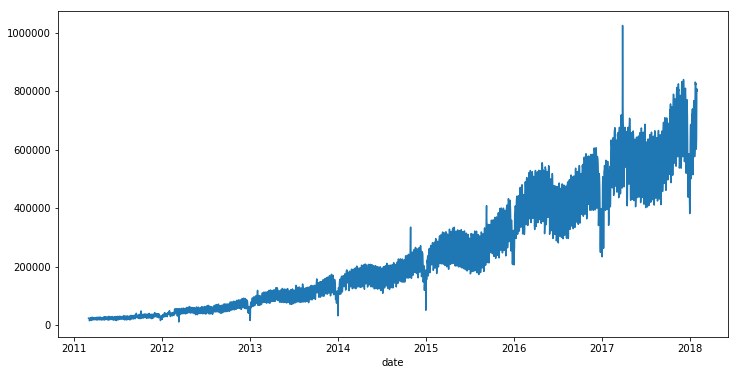

In [3]:
# Let plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['count'])
plt.xlabel('date')
plt.show()

# Modeling

In [ ]:
model = models.WaveNet(filters=64, num_layers=4)

In [ ]:
forecaster = Forecaster(
    model,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=50
)

In [ ]:
forecaster.fit(X_train, y_train, verbose=1)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel(['Loss'])

# Evaluation

In [ ]:
samples = forecaster.predict(X_test, n_samples=1000)
samples = scaler_y.inverse_transform(samples)
prediction_mean = np.mean(samples, axis=0)
prediction_lq = np.percentile(samples, q=5, axis=0)
prediction_uq = np.percentile(samples, q=95, axis=0)

In [ ]:
smape = metrics.smape(prediction_mean, y_test)
cov, perc = metrics.coverage(samples, y_test)
pinball = metrics.pinball_loss(samples, y_test)
std_smape = metrics.std_smape(samples, y_test)

print('SMAPE: {}%'.format(smape))
print('Pinball Score: {}'.format(pinball))
print('Std. SMAPE: {}%'.format(std_smape))
print('Coverage: ')
plt.plot(perc, perc)
plt.plot(perc, cov)

Lastly, we can check how our predictions compare with the data.

In [ ]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(10, 6))
plt.plot(samples[:,0,:,0].T, 'g', alpha=0.01)
plt.plot(y_test[0,:,:], 'k')
plt.plot(prediction_mean[0,:,:], 'r', linewidth=2)
plt.plot(prediction_lq[0,:,:], 'r', linewidth=2)
plt.plot(prediction_uq[0,:,:], 'r', linewidth=2)
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()